# 감정 인식 모델 학습 연습: Kaggle FER 2018
- 01.learning.ipynb

In [1]:
!python -V

Python 3.12.4


In [2]:
import sys

print(sys.version)

3.11.9 (main, Apr 19 2024, 11:43:47) [Clang 14.0.6 ]


In [3]:
# !{sys.executable} -m pip install -q tqdm # 설치 완료됨

In [4]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision.utils import make_grid
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [5]:
import torch
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}") 

MPS 장치를 지원하도록 build가 되었는가? True
MPS 장치가 사용 가능한가? True


In [6]:
import tensorflow as tf

# GPU 확인
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# 메모리 증가 허용 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


In [7]:
DATASET_HOME = "/Users/mks/Documents/GitHub/AI/archive"     # 상대경로로 설정하면 경로 오류남 ;-;
print(f"{DATASET_HOME = }")

DATASET_PATH = os.path.join(DATASET_HOME, "fer20131.csv")
print(f"{DATASET_PATH = }")

DATASET_HOME = '/Users/mks/Documents/GitHub/AI/archive'
DATASET_PATH = '/Users/mks/Documents/GitHub/AI/archive/fer20131.csv'


In [8]:
dataset = pd.read_csv(DATASET_PATH)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [9]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
dataset.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

- `Traning`, `PublicTest`를 합쳐서 학습 8 : validation 2 비율로 사용.
- `PrivateTest`는 최종 테스트 데이터로 사용

In [11]:
pixels = []

for pix in tqdm(dataset.pixels, total=len(dataset.pixels)):
    values = [int(i) for i in pix.split()]
    pixels.append(values)

print(len(pixels))

100%|███████████████████████████████████| 35887/35887 [00:04<00:00, 7599.68it/s]

35887


In [12]:
pixels = np.array(pixels)

# 0~255로 돼있는 픽셀 값을 0~1 범위로 변경
pixels = pixels / 255.0

pixels[0]

array([0.2745098 , 0.31372549, 0.32156863, ..., 0.41568627, 0.42745098,
       0.32156863])

In [13]:
dataset.drop(columns=["pixels"], axis=1, inplace=True)
dataset

,emotion,Usage
0,0,Training
1,0,Training
2,2,Training
3,4,Training
4,6,Training
...,...,...
35882,6,PrivateTest
35883,3,PrivateTest
35884,0,PrivateTest
35885,3,PrivateTest


In [14]:
pix_cols = []

# add each pixel value as a column
for i in tqdm(range(pixels.shape[1]), total=pixels.shape[1]):
    name = f"pixel_{i}"
    pix_cols.append(name)
    dataset[name] = pixels[:, i]

100%|█████████████████████████████████████| 2304/2304 [00:00<00:00, 3776.50it/s]


In [15]:
dataset.head()

,emotion,Usage,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,...,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,...,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,...,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,...,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.133333,0.121569,0.121569,0.121569,0.105882,0.121569,0.117647,0.113725,0.117647


In [16]:
emotions = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

In [17]:
class FERDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.tensor_transform = T.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row["emotion"])
        img = np.copy(row[pix_cols].values.reshape(48, 48))
        img.setflags(write=True)

        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        else:
            img = self.tensor_transform(img)

        return img, img_id


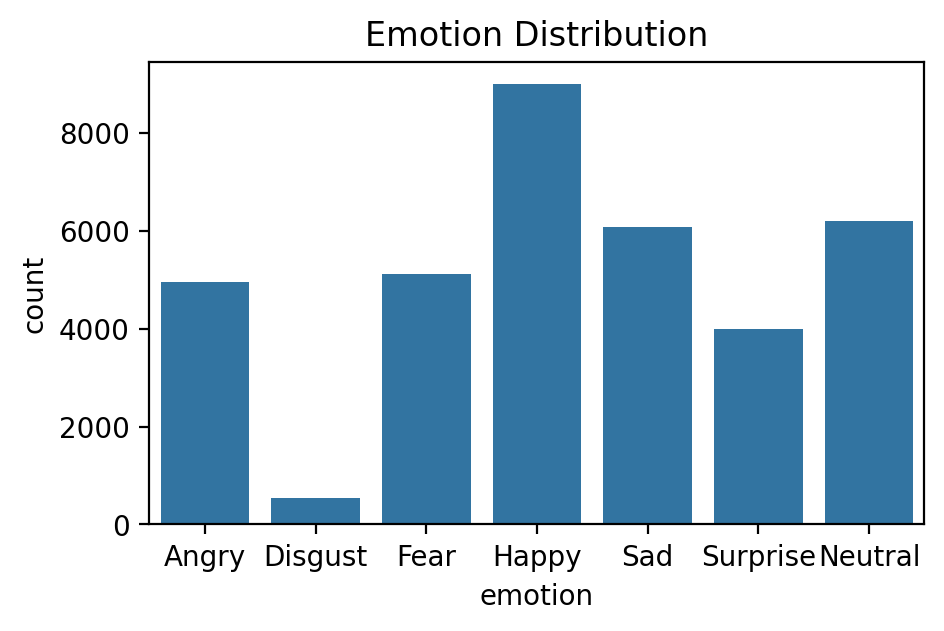

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)

sns.countplot(x=dataset.emotion, ax=ax)
ax.set_title("Emotion Distribution")
ax.set_xticks(ticks=range(0, 7), labels=emotions.values())

plt.show()
plt.close(fig)

- `Disgust` 양이 너무 적음 (데이터불균형)

## 이미지에 다양한 전처리 및 변환 작업을 수행

In [19]:
def image_transformations() -> (object, object):
    print("image_transformations")

    train_trans = [
        T.RandomCrop(48, padding=4, padding_mode="reflect"),
        T.RandomRotation(15),
        T.RandomAffine(degrees=0, translate=(0.01, 0.12), shear=(0.01, 0.03)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
    ]

    val_trans = [
        T.ToTensor(),
    ]

    train_transformations = T.Compose(train_trans)
    valid_tfms = T.Compose(val_trans)

    return train_transformations, valid_tfms

## Dataset and DataLoader

In [20]:
def get_train_dataset(
    dataframe: object, transformation: bool = True
) -> (object, object):
    """
    Returns an object on FERDataset class
    """
    dataframe = dataframe.loc[dataframe.Usage.isin(["Training", "PublicTest"])]
    dataframe = dataframe.drop("Usage", axis=1)

    # split dataset into training and validation set
    # seed 고정을 통해 난수를 일관되게 생성. 코드를 실행할 때마다 동일한 난수 순서를 얻을 수 있음
    # => 모델 학습 및 실험의 일관성 보장!
    np.random.seed(42)
    msk = np.random.rand(len(dataframe)) < 0.8

    train_df = dataframe[msk].reset_index()
    val_df = dataframe[~msk].reset_index()

    if transformation:
        train_tfms, valid_tfms = image_transformations()
    else:
        train_tfms, valid_tfms = None, None

    train_ds = FERDataset(dataframe, transform=train_tfms)
    val_ds = FERDataset(dataframe, transform=valid_tfms)

    return train_ds, val_ds

In [21]:
import torch.multiprocessing as mp
torch.multiprocessing.set_sharing_strategy('file_system')

In [22]:
def get_train_dataloader(
    dataframe: object, transformation=True, batch_size: int = 64
) -> (object, object):
    train_ds, valid_ds = get_train_dataset(dataframe, transformation=transformation)

    train_dl = DataLoader(
        train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True
    )
    valid_dl = DataLoader(valid_ds, batch_size * 2, num_workers=4, pin_memory=True)

    return train_dl, valid_dl


## Visualization

In [23]:
train_dl_un, _ = get_train_dataloader(dataset, transformation=False)
train_dl, _ = get_train_dataloader(dataset)

image_transformations


- multiprocessing error
- 해결함
- num_workers=4 로 설정
- `mp.set_start_method`를 `fork`변경 시 FERDataset 참조 에러 해결

In [24]:
mp.set_start_method('fork', force=True)

images.shape: torch.Size([64, 1, 48, 48])


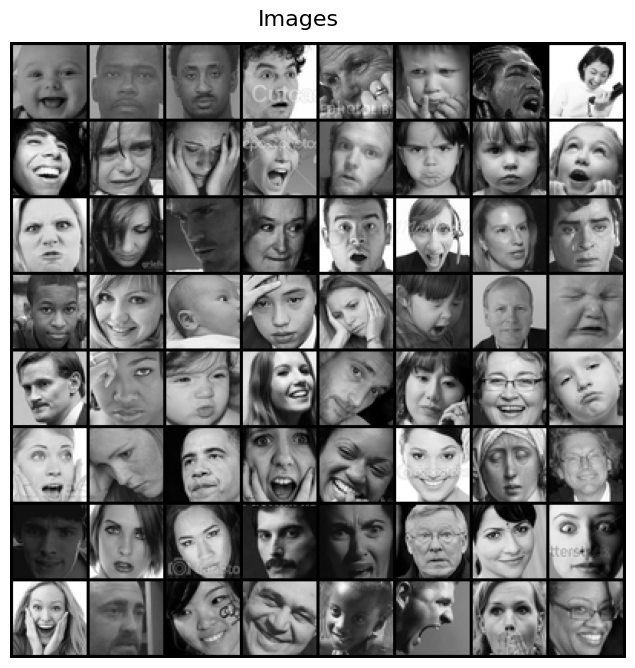

In [25]:
for images, _ in train_dl_un:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

_ = plt.suptitle("Images", y=0.92, fontsize=16)

images.shape: torch.Size([64, 1, 48, 48])


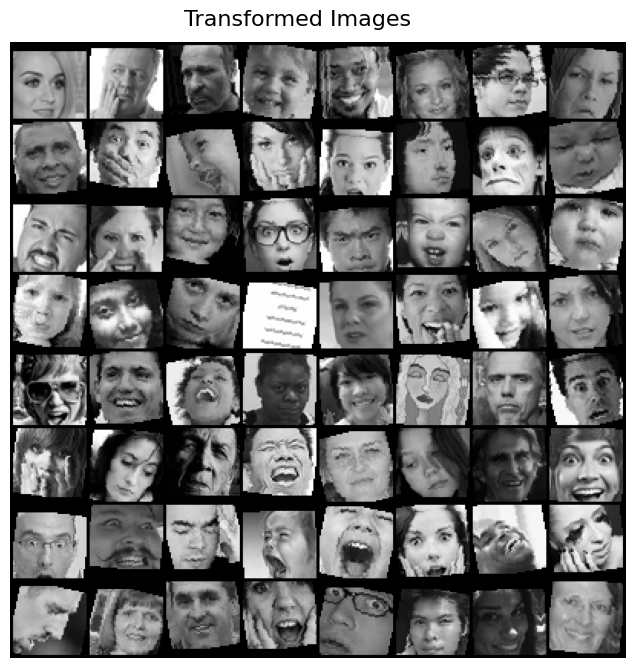

In [26]:
for images, _ in train_dl:
    print("images.shape:", images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

_ = plt.suptitle("Transformed Images", y=0.92, fontsize=16)

In [27]:
def get_default_device():
    if torch.backends.mps.is_available():  # M1/M2 GPU 사용 확인
        print("Using MPS (Apple Silicon GPU)")
        return torch.device("mps")
    #elif torch.cuda.is_available():
    #    print("Using CUDA (NVIDIA GPU)")
    #    return torch.device("cuda")
    else:
        print("Using CPU")
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [28]:
device = get_default_device()
device

Using MPS (Apple Silicon GPU)


device(type='mps')

## Model Building

In [29]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {"loss": loss, "acc": acc.detach()}

    def validation_step(self, batch):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        return {"val_loss": loss.detach(), "val_acc": acc.detach()}

    def get_metrics_epoch_end(self, outputs, validation=True):
        if validation:
            loss_ = "val_loss"
            acc_ = "val_acc"
        else:
            loss_ = "loss"
            acc_ = "acc"

        batch_losses = [x[f"{loss_}"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()

        batch_accs = [x[f"{acc_}"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {
            f"{loss_}": epoch_loss.detach().item(),
            f"{acc_}": epoch_acc.detach().item(),
        }

    def epoch_end(self, epoch, result, num_epochs):
        print(
            f"Epoch: {epoch+1}/{num_epochs} -> lr: {result['lrs'][-1]:.5f} "
            f"loss: {result['loss']:.4f}, acc: {result['acc']:.4f}, "
            f"val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}\n"
        )

## Metric

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]

    if pool:
        layers.append(nn.MaxPool2d(kernel_size=2))

    return nn.Sequential(*layers)

In [31]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # 48 - 3 + 2 + 1 = 48
        self.conv1 = conv_block(in_channels, 48, pool=True)
        self.conv2 = conv_block(48, 96, pool=True)
        self.res1 = nn.Sequential(
            conv_block(96, 96, pool=False),
            conv_block(96, 96, pool=False),
        )

        self.conv3 = conv_block(96, 192, pool=True)
        self.conv4 = conv_block(192, 384, pool=True)

        self.res2 = nn.Sequential(conv_block(384, 384), conv_block(384, 384))

        self.classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(384, num_classes),
        )
        self.network = nn.Sequential(
            self.conv1,
            self.conv2,
            self.res1,
            self.conv3,
            self.conv4,
            self.res2,
            self.classifier,
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

    def __repr__(self):
        return f"{self.network}"

    def __str__(self):
        summary(self.network, (1, 48, 48))

## Setup Training

In [32]:
@torch.no_grad()
def evaluate(model: ImageClassificationBase, val_loader: object) -> dict:
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.get_metrics_epoch_end(outputs=outputs, validation=True)


def get_lr(optimizer: object) -> float:
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_model(model_name: str,
              model: object,
              epochs: int,
              max_lr: float,
              train_loader: object,
              val_loader: object,
              weight_decay: float = 0,
              grad_clip: float = None,
              opt_func: object = torch.optim.SGD):
    torch.cuda.empty_cache()
    BEST_VAL_SCORE = 0.0
    history = []

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=max_lr,
        epochs=epochs,
        steps_per_epoch=len(train_loader)
    )

    for epoch in range(epochs):
        train_history = []
        lrs = []

        # Training Phase
        model.train()
        for batch in tqdm(train_loader, ascii=True, desc=f'Epoch: {epoch+1}/{epochs}'):
            info = model.training_step(batch)
            loss = info['loss']

            train_history.append(info)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()

        train_result = model.get_metrics_epoch_end(
            train_history, validation=False)
        val_result = evaluate(model, val_loader)
        result = {**train_result, **val_result}
        result['lrs'] = lrs

        model.epoch_end(epoch, result, epochs)
        # 최고 score 모델 저장 코드
        if result['val_acc'] > BEST_VAL_SCORE:
            BEST_VAL_SCORE = result['val_acc']
            save_name = f"{model_name}_epoch-{epoch+1}_score-{round(result['val_acc'], 4)}.pth"
            !rm -f '{model_name}'_*
            torch.save(model.state_dict(), save_name)

        history.append(result)
    return history

In [33]:
def get_test_dataloader(dataframe: object, batch_size: int = 128) -> object:
    test_df = dataframe.loc[dataset.Usage.isin(["PrivateTest"])]

    test_df = test_df.drop("Usage", axis=1)

    _, valid_tfms = image_transformations()

    test_dataset = FERDataset(test_df, transform=valid_tfms)
    test_dl = DataLoader(test_dataset, batch_size, num_workers=8, pin_memory=True)

    # move loader to GPU
    test_dl = DeviceDataLoader(test_dl, device)
    return test_dl

In [34]:
def load_best(model_name: str) -> object:
    best_model = models[model_name]

    path = "./"
    file_path = ""

    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path, i)) and i.startswith(f"{model_name}"):
            file_path = os.path.join(path, i)

    print(f"Loaded model: {file_path[2:]} weights")
    best_model.load_state_dict(torch.load(file_path))

    best_model = to_device(best_model, device)
    return best_model


@torch.no_grad()
def generate_prediction(model_name: str) -> None:
    test_dl = get_test_dataloader(dataset)

    model = load_best(model_name)

    torch.cuda.empty_cache()

    with torch.no_grad():
        model.eval()
        outputs = [model.validation_step(batch) for batch in test_dl]
        metrics = model.get_metrics_epoch_end(outputs=outputs, validation=True)

    print(
        f"Test Scores:\n Loss: {round(metrics['val_loss'], 3)}, "
        f"Accuracy: {round(metrics['val_acc'], 3)}"
    )

In [35]:
def end_to_end(model_name: str, parameters: dict = None) -> dict:
    torch.cuda.empty_cache()

    train_dl, valid_dl = get_train_dataloader(
        dataset, batch_size=parameters["batch_size"]
    )

    train_dl = DeviceDataLoader(train_dl, device)
    valid_dl = DeviceDataLoader(valid_dl, device)

    model = models[model_name]

    model = to_device(model, device)

    # train model
    history = fit_model(
        model_name,
        model,
        parameters["epochs"],
        parameters["max_lr"],
        train_dl,
        valid_dl,
        parameters["weight_decay"],
        parameters["grad_clip"],
        parameters["opt_func"],
    )

    # cleaning
    torch.cuda.empty_cache()

    # generate predictions
    print("Genearating predictions on the Test set")
    generate_prediction(model_name)
    return history

In [36]:
def plot_accuracies(history):
    train_acc = [r['acc'] for r in history]
    val_acc = [r['val_acc'] for r in history]
    plt.plot(train_acc, '-kx', label="train_acc")
    plt.plot(val_acc, '-rx', label="val_acc")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_acc)),
                   labels=[str(i) for i in range(1, len(train_acc)+1)])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. epochs')


def plot_losses(history):
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, '-kx', label="train_loss")
    plt.plot(val_losses, '-rx', label="val_loss")
    plt.legend()
    _ = plt.xticks(ticks=range(len(train_losses)),
                   labels=[str(i) for i in range(1, len(train_losses)+1)])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')


def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [37]:
models = {
    "ResNet9": ResNet9(in_channels=1, num_classes=7),
}

In [38]:
models["ResNet9"].__str__()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 48, 48]             480
       BatchNorm2d-2           [-1, 48, 48, 48]              96
              ReLU-3           [-1, 48, 48, 48]               0
         MaxPool2d-4           [-1, 48, 24, 24]               0
            Conv2d-5           [-1, 96, 24, 24]          41,568
       BatchNorm2d-6           [-1, 96, 24, 24]             192
              ReLU-7           [-1, 96, 24, 24]               0
         MaxPool2d-8           [-1, 96, 12, 12]               0
            Conv2d-9           [-1, 96, 12, 12]          83,040
      BatchNorm2d-10           [-1, 96, 12, 12]             192
             ReLU-11           [-1, 96, 12, 12]               0
           Conv2d-12           [-1, 96, 12, 12]          83,040
      BatchNorm2d-13           [-1, 96, 12, 12]             192
             ReLU-14           [-1, 96,

In [39]:
training_parameters = {
    "batch_size": 512,
    "epochs": 100,       # epochs 200 -> 50
    "max_lr": 0.01,
    "weight_decay": 0.0001,
    "grad_clip": 0.1,
    "opt_func": torch.optim.Adam,
}

In [40]:
model_name = "ResNet9"

history = end_to_end(model_name, training_parameters)

image_transformations


Epoch: 1/100: 100%|#############################| 64/64 [00:21<00:00,  3.03it/s]


Epoch: 1/100 -> lr: 0.00043 loss: 1.9662, acc: 0.2439, val_loss: 1.7842, val_acc: 0.2686

zsh:1: no matches found: ResNet9_*


Epoch: 2/100: 100%|#############################| 64/64 [00:15<00:00,  4.25it/s]


Epoch: 2/100 -> lr: 0.00050 loss: 1.7171, acc: 0.3222, val_loss: 1.5098, val_acc: 0.4172



Epoch: 3/100: 100%|#############################| 64/64 [00:15<00:00,  4.18it/s]


Epoch: 3/100 -> lr: 0.00063 loss: 1.5506, acc: 0.3985, val_loss: 1.5657, val_acc: 0.4161



Epoch: 4/100: 100%|#############################| 64/64 [00:15<00:00,  4.24it/s]


Epoch: 4/100 -> lr: 0.00081 loss: 1.4430, acc: 0.4440, val_loss: 1.2928, val_acc: 0.5095



Epoch: 5/100: 100%|#############################| 64/64 [00:15<00:00,  4.21it/s]


Epoch: 5/100 -> lr: 0.00104 loss: 1.3672, acc: 0.4759, val_loss: 1.2521, val_acc: 0.5244



Epoch: 6/100: 100%|#############################| 64/64 [00:15<00:00,  4.19it/s]


Epoch: 6/100 -> lr: 0.00131 loss: 1.2906, acc: 0.5088, val_loss: 1.1939, val_acc: 0.5429



Epoch: 7/100: 100%|#############################| 64/64 [00:15<00:00,  4.24it/s]


Epoch: 7/100 -> lr: 0.00163 loss: 1.2613, acc: 0.5179, val_loss: 1.3472, val_acc: 0.5097



Epoch: 8/100: 100%|#############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 8/100 -> lr: 0.00198 loss: 1.2289, acc: 0.5306, val_loss: 1.3343, val_acc: 0.4765



Epoch: 9/100: 100%|#############################| 64/64 [00:15<00:00,  4.23it/s]


Epoch: 9/100 -> lr: 0.00237 loss: 1.2135, acc: 0.5395, val_loss: 1.1563, val_acc: 0.5576



Epoch: 10/100: 100%|############################| 64/64 [00:15<00:00,  4.19it/s]


Epoch: 10/100 -> lr: 0.00280 loss: 1.1950, acc: 0.5472, val_loss: 1.2072, val_acc: 0.5358



Epoch: 11/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 11/100 -> lr: 0.00324 loss: 1.1704, acc: 0.5562, val_loss: 1.2027, val_acc: 0.5574



Epoch: 12/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 12/100 -> lr: 0.00371 loss: 1.1467, acc: 0.5662, val_loss: 1.5164, val_acc: 0.4438



Epoch: 13/100: 100%|############################| 64/64 [00:15<00:00,  4.24it/s]


Epoch: 13/100 -> lr: 0.00420 loss: 1.1616, acc: 0.5574, val_loss: 1.3650, val_acc: 0.4807



Epoch: 14/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 14/100 -> lr: 0.00469 loss: 1.1390, acc: 0.5653, val_loss: 1.1345, val_acc: 0.5813



Epoch: 15/100: 100%|############################| 64/64 [00:14<00:00,  4.31it/s]


Epoch: 15/100 -> lr: 0.00520 loss: 1.1212, acc: 0.5793, val_loss: 1.1804, val_acc: 0.5463



Epoch: 16/100: 100%|############################| 64/64 [00:14<00:00,  4.30it/s]


Epoch: 16/100 -> lr: 0.00570 loss: 1.1065, acc: 0.5809, val_loss: 1.4539, val_acc: 0.4931



Epoch: 17/100: 100%|############################| 64/64 [00:14<00:00,  4.30it/s]


Epoch: 17/100 -> lr: 0.00619 loss: 1.0930, acc: 0.5898, val_loss: 1.1942, val_acc: 0.5687



Epoch: 18/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 18/100 -> lr: 0.00668 loss: 1.0786, acc: 0.5923, val_loss: 1.7622, val_acc: 0.3923



Epoch: 19/100: 100%|############################| 64/64 [00:15<00:00,  4.24it/s]


Epoch: 19/100 -> lr: 0.00715 loss: 1.0788, acc: 0.5910, val_loss: 1.5194, val_acc: 0.4508



Epoch: 20/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 20/100 -> lr: 0.00760 loss: 1.0552, acc: 0.5994, val_loss: 1.1454, val_acc: 0.5434



Epoch: 21/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 21/100 -> lr: 0.00802 loss: 1.0385, acc: 0.6094, val_loss: 1.2427, val_acc: 0.5413



Epoch: 22/100: 100%|############################| 64/64 [00:14<00:00,  4.30it/s]


Epoch: 22/100 -> lr: 0.00841 loss: 1.0325, acc: 0.6130, val_loss: 1.0607, val_acc: 0.6022



Epoch: 23/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 23/100 -> lr: 0.00877 loss: 1.0295, acc: 0.6126, val_loss: 1.1051, val_acc: 0.5641



Epoch: 24/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 24/100 -> lr: 0.00908 loss: 1.0261, acc: 0.6132, val_loss: 1.0221, val_acc: 0.5977



Epoch: 25/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 25/100 -> lr: 0.00936 loss: 1.0151, acc: 0.6181, val_loss: 1.0810, val_acc: 0.5739



Epoch: 26/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 26/100 -> lr: 0.00958 loss: 1.0139, acc: 0.6194, val_loss: 1.1337, val_acc: 0.5734



Epoch: 27/100: 100%|############################| 64/64 [00:17<00:00,  3.72it/s]


Epoch: 27/100 -> lr: 0.00976 loss: 0.9973, acc: 0.6239, val_loss: 1.1094, val_acc: 0.5858



Epoch: 28/100: 100%|############################| 64/64 [00:16<00:00,  3.85it/s]


Epoch: 28/100 -> lr: 0.00989 loss: 1.0061, acc: 0.6215, val_loss: 1.0638, val_acc: 0.5953



Epoch: 29/100: 100%|############################| 64/64 [00:15<00:00,  4.04it/s]


Epoch: 29/100 -> lr: 0.00997 loss: 0.9956, acc: 0.6255, val_loss: 1.3301, val_acc: 0.5185



Epoch: 30/100: 100%|############################| 64/64 [00:17<00:00,  3.73it/s]


Epoch: 30/100 -> lr: 0.01000 loss: 0.9955, acc: 0.6243, val_loss: 1.1206, val_acc: 0.5845



Epoch: 31/100: 100%|############################| 64/64 [00:16<00:00,  3.85it/s]


Epoch: 31/100 -> lr: 0.00999 loss: 0.9965, acc: 0.6235, val_loss: 1.3716, val_acc: 0.4826



Epoch: 32/100: 100%|############################| 64/64 [00:15<00:00,  4.24it/s]


Epoch: 32/100 -> lr: 0.00998 loss: 0.9920, acc: 0.6235, val_loss: 1.0621, val_acc: 0.6023



Epoch: 33/100: 100%|############################| 64/64 [00:15<00:00,  4.24it/s]


Epoch: 33/100 -> lr: 0.00995 loss: 0.9727, acc: 0.6344, val_loss: 1.0983, val_acc: 0.5942



Epoch: 34/100: 100%|############################| 64/64 [00:15<00:00,  4.18it/s]


Epoch: 34/100 -> lr: 0.00992 loss: 0.9775, acc: 0.6317, val_loss: 1.2776, val_acc: 0.5118



Epoch: 35/100: 100%|############################| 64/64 [00:15<00:00,  4.27it/s]


Epoch: 35/100 -> lr: 0.00987 loss: 0.9737, acc: 0.6357, val_loss: 1.0388, val_acc: 0.6111



Epoch: 36/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 36/100 -> lr: 0.00982 loss: 0.9593, acc: 0.6401, val_loss: 0.9698, val_acc: 0.6305



Epoch: 37/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 37/100 -> lr: 0.00976 loss: 0.9531, acc: 0.6437, val_loss: 1.1107, val_acc: 0.5814



Epoch: 38/100: 100%|############################| 64/64 [00:14<00:00,  4.30it/s]


Epoch: 38/100 -> lr: 0.00968 loss: 0.9728, acc: 0.6342, val_loss: 1.3931, val_acc: 0.4946



Epoch: 39/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 39/100 -> lr: 0.00960 loss: 0.9605, acc: 0.6376, val_loss: 1.0848, val_acc: 0.5839



Epoch: 40/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 40/100 -> lr: 0.00950 loss: 0.9546, acc: 0.6414, val_loss: 1.0937, val_acc: 0.5827



Epoch: 41/100: 100%|############################| 64/64 [00:15<00:00,  4.17it/s]


Epoch: 41/100 -> lr: 0.00940 loss: 0.9544, acc: 0.6412, val_loss: 1.1326, val_acc: 0.5629



Epoch: 42/100: 100%|############################| 64/64 [00:15<00:00,  4.23it/s]


Epoch: 42/100 -> lr: 0.00929 loss: 0.9484, acc: 0.6421, val_loss: 1.3404, val_acc: 0.4680



Epoch: 43/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 43/100 -> lr: 0.00917 loss: 0.9538, acc: 0.6401, val_loss: 1.2648, val_acc: 0.5418



Epoch: 44/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 44/100 -> lr: 0.00905 loss: 0.9481, acc: 0.6430, val_loss: 1.0091, val_acc: 0.6133



Epoch: 45/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 45/100 -> lr: 0.00891 loss: 0.9415, acc: 0.6438, val_loss: 1.1853, val_acc: 0.5381



Epoch: 46/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 46/100 -> lr: 0.00877 loss: 0.9329, acc: 0.6504, val_loss: 1.5223, val_acc: 0.4181



Epoch: 47/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 47/100 -> lr: 0.00861 loss: 0.9473, acc: 0.6455, val_loss: 0.9112, val_acc: 0.6551



Epoch: 48/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 48/100 -> lr: 0.00846 loss: 0.9259, acc: 0.6539, val_loss: 0.9955, val_acc: 0.6240



Epoch: 49/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 49/100 -> lr: 0.00829 loss: 0.9315, acc: 0.6493, val_loss: 0.9445, val_acc: 0.6459



Epoch: 50/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 50/100 -> lr: 0.00812 loss: 0.9201, acc: 0.6564, val_loss: 1.0800, val_acc: 0.5817



Epoch: 51/100: 100%|############################| 64/64 [00:15<00:00,  4.17it/s]


Epoch: 51/100 -> lr: 0.00794 loss: 0.9503, acc: 0.6425, val_loss: 1.0461, val_acc: 0.6044



Epoch: 52/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 52/100 -> lr: 0.00775 loss: 0.9270, acc: 0.6518, val_loss: 1.0081, val_acc: 0.6110



Epoch: 53/100: 100%|############################| 64/64 [00:15<00:00,  4.22it/s]


Epoch: 53/100 -> lr: 0.00756 loss: 0.9156, acc: 0.6574, val_loss: 1.4188, val_acc: 0.4941



Epoch: 54/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 54/100 -> lr: 0.00737 loss: 0.9336, acc: 0.6477, val_loss: 0.9564, val_acc: 0.6352



Epoch: 55/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 55/100 -> lr: 0.00717 loss: 0.9230, acc: 0.6536, val_loss: 0.8773, val_acc: 0.6679



Epoch: 56/100: 100%|############################| 64/64 [00:14<00:00,  4.31it/s]


Epoch: 56/100 -> lr: 0.00697 loss: 0.9051, acc: 0.6574, val_loss: 0.9639, val_acc: 0.6394



Epoch: 57/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 57/100 -> lr: 0.00676 loss: 0.9169, acc: 0.6541, val_loss: 1.1644, val_acc: 0.5427



Epoch: 58/100: 100%|############################| 64/64 [00:15<00:00,  4.21it/s]


Epoch: 58/100 -> lr: 0.00655 loss: 0.9074, acc: 0.6597, val_loss: 1.1582, val_acc: 0.5462



Epoch: 59/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 59/100 -> lr: 0.00633 loss: 0.9066, acc: 0.6598, val_loss: 0.8312, val_acc: 0.6880



Epoch: 60/100: 100%|############################| 64/64 [00:15<00:00,  4.23it/s]


Epoch: 60/100 -> lr: 0.00611 loss: 0.8900, acc: 0.6682, val_loss: 0.9422, val_acc: 0.6438



Epoch: 61/100: 100%|############################| 64/64 [00:16<00:00,  3.96it/s]


Epoch: 61/100 -> lr: 0.00589 loss: 0.8986, acc: 0.6609, val_loss: 0.9658, val_acc: 0.6410



Epoch: 62/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 62/100 -> lr: 0.00567 loss: 0.8954, acc: 0.6635, val_loss: 0.8327, val_acc: 0.6898



Epoch: 63/100: 100%|############################| 64/64 [00:15<00:00,  4.20it/s]


Epoch: 63/100 -> lr: 0.00545 loss: 0.8705, acc: 0.6764, val_loss: 0.9484, val_acc: 0.6430



Epoch: 64/100: 100%|############################| 64/64 [00:15<00:00,  4.24it/s]


Epoch: 64/100 -> lr: 0.00522 loss: 0.8577, acc: 0.6761, val_loss: 0.8054, val_acc: 0.6965



Epoch: 65/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 65/100 -> lr: 0.00500 loss: 0.8585, acc: 0.6785, val_loss: 0.7972, val_acc: 0.7024



Epoch: 66/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 66/100 -> lr: 0.00478 loss: 0.8600, acc: 0.6798, val_loss: 0.8601, val_acc: 0.6756



Epoch: 67/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 67/100 -> lr: 0.00455 loss: 0.8571, acc: 0.6776, val_loss: 0.8606, val_acc: 0.6769



Epoch: 68/100: 100%|############################| 64/64 [00:14<00:00,  4.30it/s]


Epoch: 68/100 -> lr: 0.00433 loss: 0.8623, acc: 0.6768, val_loss: 0.7989, val_acc: 0.7041



Epoch: 69/100: 100%|############################| 64/64 [00:15<00:00,  4.27it/s]


Epoch: 69/100 -> lr: 0.00411 loss: 0.8435, acc: 0.6825, val_loss: 0.7668, val_acc: 0.7137



Epoch: 70/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 70/100 -> lr: 0.00389 loss: 0.8244, acc: 0.6937, val_loss: 0.7638, val_acc: 0.7171



Epoch: 71/100: 100%|############################| 64/64 [00:14<00:00,  4.30it/s]


Epoch: 71/100 -> lr: 0.00367 loss: 0.8440, acc: 0.6857, val_loss: 0.7635, val_acc: 0.7116



Epoch: 72/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 72/100 -> lr: 0.00345 loss: 0.8092, acc: 0.7000, val_loss: 0.7274, val_acc: 0.7296



Epoch: 73/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 73/100 -> lr: 0.00324 loss: 0.7901, acc: 0.7045, val_loss: 0.7935, val_acc: 0.7018



Epoch: 74/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 74/100 -> lr: 0.00303 loss: 0.7906, acc: 0.7036, val_loss: 0.6886, val_acc: 0.7411



Epoch: 75/100: 100%|############################| 64/64 [00:16<00:00,  3.97it/s]


Epoch: 75/100 -> lr: 0.00283 loss: 0.7727, acc: 0.7102, val_loss: 0.8010, val_acc: 0.6945



Epoch: 76/100: 100%|############################| 64/64 [00:16<00:00,  3.78it/s]


Epoch: 76/100 -> lr: 0.00263 loss: 0.7646, acc: 0.7153, val_loss: 0.7201, val_acc: 0.7267



Epoch: 77/100: 100%|############################| 64/64 [00:15<00:00,  4.17it/s]


Epoch: 77/100 -> lr: 0.00244 loss: 0.7568, acc: 0.7185, val_loss: 0.6502, val_acc: 0.7591



Epoch: 78/100: 100%|############################| 64/64 [00:15<00:00,  4.16it/s]


Epoch: 78/100 -> lr: 0.00225 loss: 0.7351, acc: 0.7250, val_loss: 0.6619, val_acc: 0.7504



Epoch: 79/100: 100%|############################| 64/64 [00:15<00:00,  4.19it/s]


Epoch: 79/100 -> lr: 0.00206 loss: 0.7261, acc: 0.7299, val_loss: 0.6321, val_acc: 0.7644



Epoch: 80/100: 100%|############################| 64/64 [00:15<00:00,  4.02it/s]


Epoch: 80/100 -> lr: 0.00188 loss: 0.7080, acc: 0.7339, val_loss: 0.6167, val_acc: 0.7712



Epoch: 81/100: 100%|############################| 64/64 [00:15<00:00,  4.19it/s]


Epoch: 81/100 -> lr: 0.00171 loss: 0.7078, acc: 0.7362, val_loss: 0.5991, val_acc: 0.7763



Epoch: 82/100: 100%|############################| 64/64 [00:15<00:00,  4.20it/s]


Epoch: 82/100 -> lr: 0.00154 loss: 0.6802, acc: 0.7452, val_loss: 0.5628, val_acc: 0.7913



Epoch: 83/100: 100%|############################| 64/64 [00:15<00:00,  4.23it/s]


Epoch: 83/100 -> lr: 0.00139 loss: 0.6738, acc: 0.7472, val_loss: 0.5706, val_acc: 0.7866



Epoch: 84/100: 100%|############################| 64/64 [00:15<00:00,  4.27it/s]


Epoch: 84/100 -> lr: 0.00123 loss: 0.6656, acc: 0.7518, val_loss: 0.5348, val_acc: 0.8040



Epoch: 85/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 85/100 -> lr: 0.00109 loss: 0.6359, acc: 0.7657, val_loss: 0.5307, val_acc: 0.8025



Epoch: 86/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 86/100 -> lr: 0.00095 loss: 0.6162, acc: 0.7703, val_loss: 0.5288, val_acc: 0.8001



Epoch: 87/100: 100%|############################| 64/64 [00:14<00:00,  4.28it/s]


Epoch: 87/100 -> lr: 0.00083 loss: 0.6069, acc: 0.7747, val_loss: 0.4815, val_acc: 0.8227



Epoch: 88/100: 100%|############################| 64/64 [00:15<00:00,  4.21it/s]


Epoch: 88/100 -> lr: 0.00071 loss: 0.5870, acc: 0.7828, val_loss: 0.4638, val_acc: 0.8307



Epoch: 89/100: 100%|############################| 64/64 [00:15<00:00,  4.27it/s]


Epoch: 89/100 -> lr: 0.00060 loss: 0.5682, acc: 0.7898, val_loss: 0.4554, val_acc: 0.8331



Epoch: 90/100: 100%|############################| 64/64 [00:14<00:00,  4.27it/s]


Epoch: 90/100 -> lr: 0.00050 loss: 0.5598, acc: 0.7907, val_loss: 0.4644, val_acc: 0.8274



Epoch: 91/100: 100%|############################| 64/64 [00:14<00:00,  4.32it/s]


Epoch: 91/100 -> lr: 0.00040 loss: 0.5439, acc: 0.7997, val_loss: 0.4247, val_acc: 0.8437



Epoch: 92/100: 100%|############################| 64/64 [00:15<00:00,  4.20it/s]


Epoch: 92/100 -> lr: 0.00032 loss: 0.5317, acc: 0.8034, val_loss: 0.4138, val_acc: 0.8475



Epoch: 93/100: 100%|############################| 64/64 [00:15<00:00,  4.16it/s]


Epoch: 93/100 -> lr: 0.00024 loss: 0.5190, acc: 0.8086, val_loss: 0.4060, val_acc: 0.8514



Epoch: 94/100: 100%|############################| 64/64 [00:15<00:00,  4.22it/s]


Epoch: 94/100 -> lr: 0.00018 loss: 0.5100, acc: 0.8093, val_loss: 0.3940, val_acc: 0.8558



Epoch: 95/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 95/100 -> lr: 0.00013 loss: 0.5011, acc: 0.8145, val_loss: 0.3871, val_acc: 0.8581



Epoch: 96/100: 100%|############################| 64/64 [00:14<00:00,  4.29it/s]


Epoch: 96/100 -> lr: 0.00008 loss: 0.4947, acc: 0.8167, val_loss: 0.3818, val_acc: 0.8611



Epoch: 97/100: 100%|############################| 64/64 [00:15<00:00,  4.06it/s]


Epoch: 97/100 -> lr: 0.00005 loss: 0.4874, acc: 0.8213, val_loss: 0.3789, val_acc: 0.8622



Epoch: 98/100: 100%|############################| 64/64 [00:15<00:00,  4.19it/s]


Epoch: 98/100 -> lr: 0.00002 loss: 0.4890, acc: 0.8212, val_loss: 0.3771, val_acc: 0.8626



Epoch: 99/100: 100%|############################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 99/100 -> lr: 0.00001 loss: 0.4860, acc: 0.8214, val_loss: 0.3765, val_acc: 0.8621



Epoch: 100/100: 100%|###########################| 64/64 [00:15<00:00,  4.26it/s]


Epoch: 100/100 -> lr: 0.00000 loss: 0.4884, acc: 0.8153, val_loss: 0.3753, val_acc: 0.8633

Genearating predictions on the Test set
image_transformations
Loaded model: ResNet9_epoch-100_score-0.8633.pth weights
Test Scores:
 Loss: 0.939, Accuracy: 0.709


### `ResNet9_epoch-100_score-0.8633.pth`로 model 디렉토리에 저장